## Pandas

In [1]:
import matplotlib as plt
import pandas as pd
from openbb import obb
from pandas.plotting import bootstrap_plot, scatter_matrix
obb.user.preferences.output_type = "dataframe"

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
df = obb.equity.price.historical("NVDA",
                                 start_date="2023-12-31",
                                 end_date="2024-12-31",
                                 provider="yfinance")

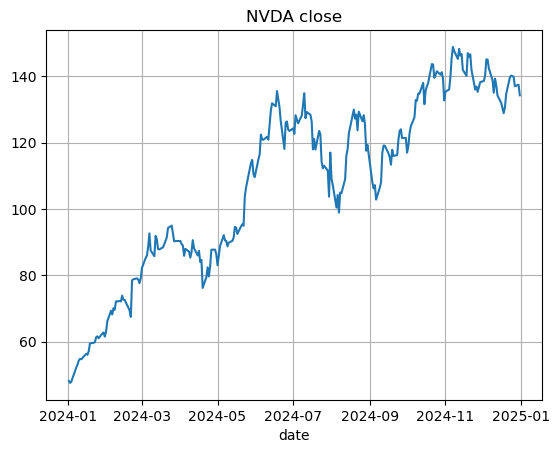

In [4]:
df.close.plot(title="NVDA close",
             grid=True);

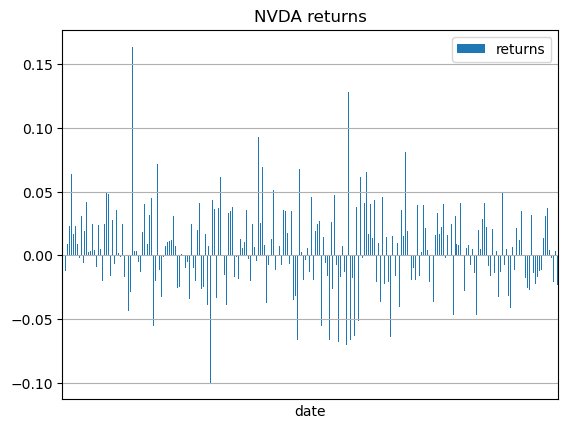

In [5]:
returns = df.close.pct_change()
returns.name = "returns"
returns.plot.bar(title="NVDA returns",
                 grid=True,
                 legend=True, 
                 xticks=[]);

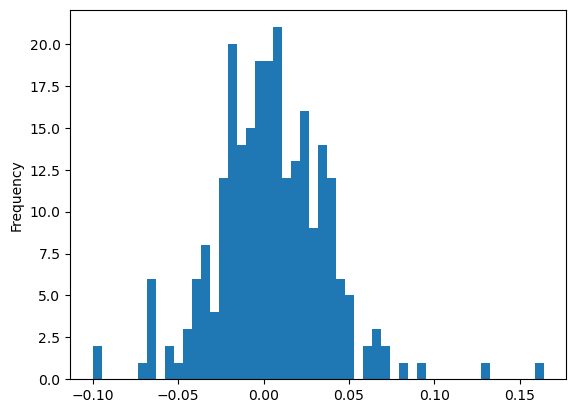

In [6]:
returns.plot.hist(bins=50);

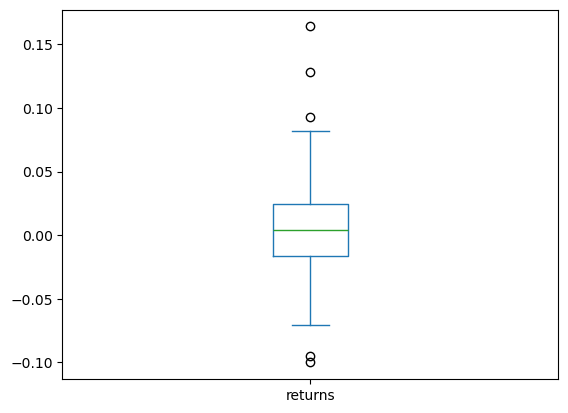

In [7]:
returns.plot.box();

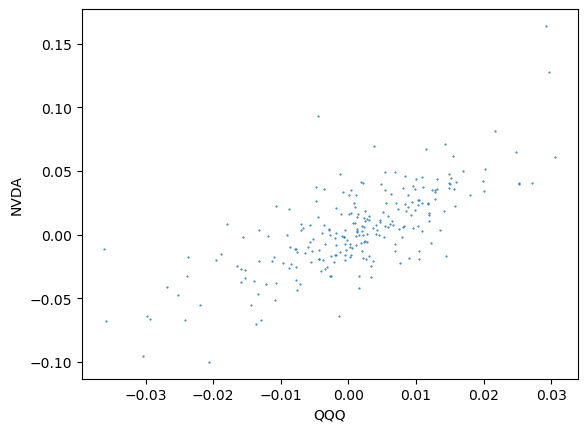

In [8]:
qqq = obb.equity.price.historical("QQQ", provider="yfinance")
qqq_returns = qqq.close.pct_change()
asset_bench = pd.concat([returns, qqq_returns], axis=1)
asset_bench.columns = ["NVDA", "QQQ"]
asset_bench.plot.scatter(x="QQQ", y="NVDA", s=0.25);

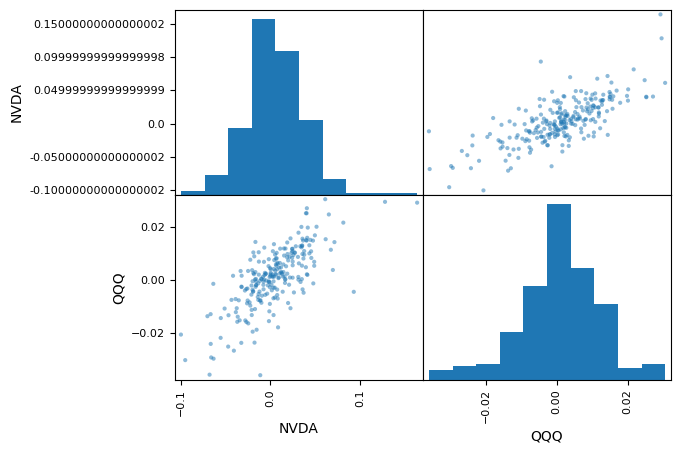

In [9]:
scatter_matrix(asset_bench);

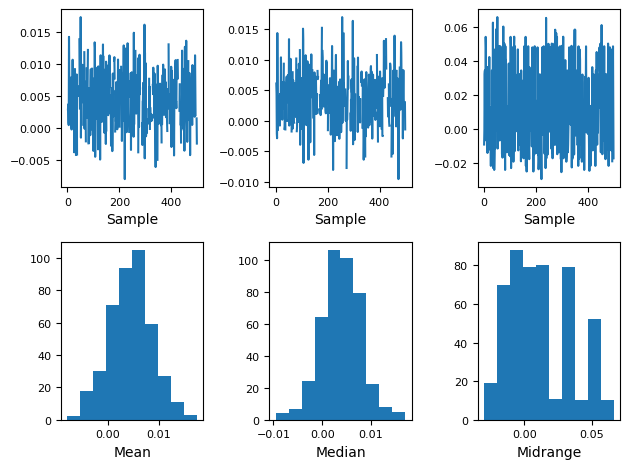

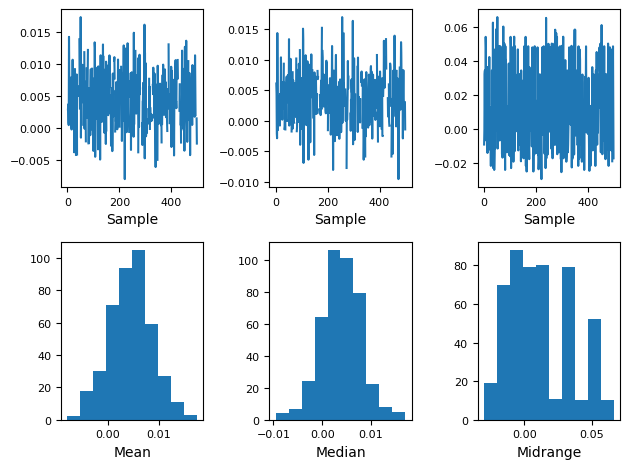

In [10]:
bootstrap_plot(returns)

### Implied Volatility Surface

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from openbb import obb
obb.user.preferences.output_type = "dataframe"

In [12]:
chains = obb.derivatives.options.chains("NVDA", provider="cboe",)

In [13]:
calls = chains[chains.option_type == "call"]

In [14]:
calls = calls[(calls.dte < 90) & (calls.strike >= 100)]
calls.drop_duplicates(subset=["strike", "dte"], keep=False, inplace=True)

In [15]:
vol_surface = (calls.pivot(index="strike", columns="dte", values="implied_volatility").dropna(how="all", axis=1))

In [16]:
strike, dte = np.meshgrid(vol_surface.columns, vol_surface.index)

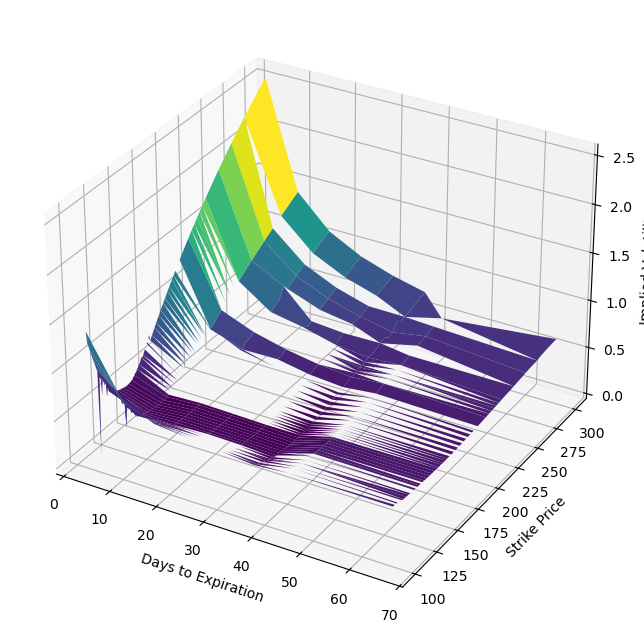

In [17]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Days to Expiration")
ax.set_ylabel("Strike Price")
ax.set_zlabel("Implied Volatility")
ax.plot_surface(strike, dte, vol_surface.values, cmap="viridis");

## Seaborn

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from openbb import obb
obb.user.preferences.output_type = "dataframe"

In [19]:
data = obb.equity.price.historical(["NVDA", "SPY"],
                                   start_date="2023-12-31",
                                   end_date="2024-12-31",
                                   provider="yfinance").pivot(columns="symbol", values="close")

In [20]:
returns = data.pct_change(fill_method=None).dropna()

In [21]:
returns = returns.reset_index()
melted = pd.melt(returns, id_vars=["date"],
                 value_vars=["NVDA"],
                 var_name="stock",
                 value_name="returns")

In [22]:
melted["month"] = pd.to_datetime(melted.date).dt.to_period("M")

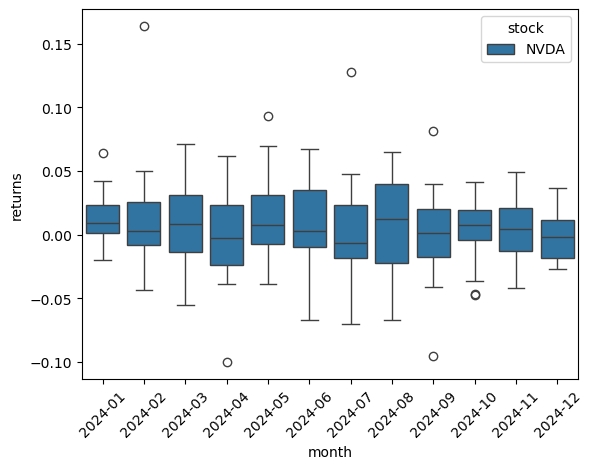

In [23]:
g = sns.boxplot(x="month",
                y="returns",
                hue="stock",
                data=melted)
g.set_xticklabels(melted["month"].unique(),
                  rotation=45);

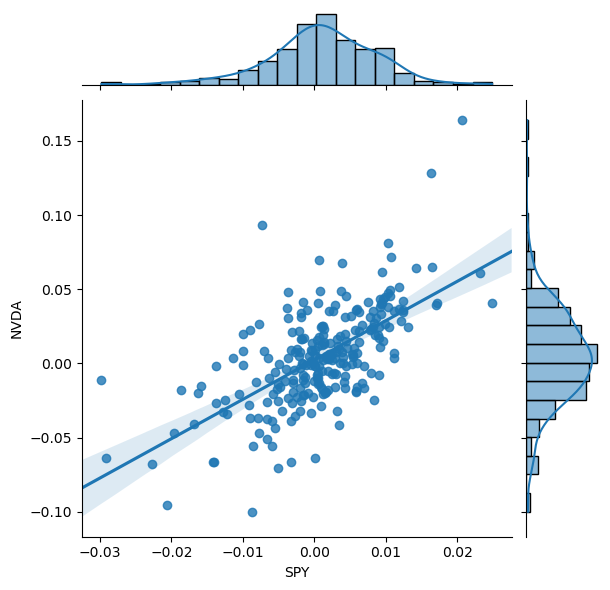

In [24]:
g = sns.jointplot(x="SPY",
                  y="NVDA",
                  data=returns,
                  kind="reg",
                  truncate=False,)

## DJIA correlation matrix

In [25]:
dji = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")[2]

In [26]:
dji_data = obb.equity.price.historical(dji.Symbol,
                                       start_date="2020-01-01",
                                       provider="yfinance").pivot(columns="symbol", values="close")

In [27]:
dji_returns = dji_data.pct_change(fill_method=None).dropna()

In [28]:
corr = dji_returns.corr()

In [29]:
mask = np.triu(np.ones_like(corr, dtype=bool))

In [30]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

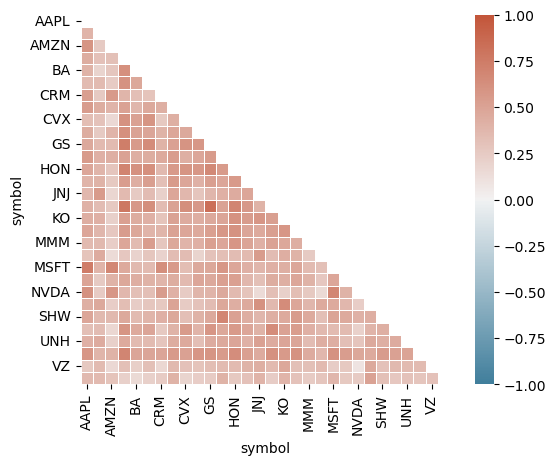

In [31]:
plt.rcParams["font.size"] = 10
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            square=True,
            linewidths=0.5,);